# Workgroup 5

Authors: Valerie Dube, Erzo Garay, Juan Marcos Guerrero y Matias Villalba

## Replication and Data analysis

In [45]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import hdmpy as hdm

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LassoCV, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

### 1. Descriptives

#### 1.1. Descriptive table

In [31]:
# Import data and see first observations
df = pd.read_csv("../../data/processed_esti.csv")
df.head()

,y,w,gender_female,gender_male,gender_transgender,ethnicgrp_asian,ethnicgrp_black,ethnicgrp_mixed_multiple,ethnicgrp_other,ethnicgrp_white,partners1,postlaunch,msm,age,imd_decile
0,1,1,0,1,0,0,0,1,0,0,0,1,0,27,5
1,0,0,0,1,0,0,0,0,0,1,0,0,0,19,6
2,0,1,0,1,0,0,1,0,0,0,0,1,0,26,4
3,0,0,1,0,0,0,0,0,0,1,1,0,0,20,2
4,1,1,1,0,0,1,0,0,0,0,0,1,0,24,3


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   y                         1739 non-null   int64
 1   w                         1739 non-null   int64
 2   gender_female             1739 non-null   int64
 3   gender_male               1739 non-null   int64
 4   gender_transgender        1739 non-null   int64
 5   ethnicgrp_asian           1739 non-null   int64
 6   ethnicgrp_black           1739 non-null   int64
 7   ethnicgrp_mixed_multiple  1739 non-null   int64
 8   ethnicgrp_other           1739 non-null   int64
 9   ethnicgrp_white           1739 non-null   int64
 10  partners1                 1739 non-null   int64
 11  postlaunch                1739 non-null   int64
 12  msm                       1739 non-null   int64
 13  age                       1739 non-null   int64
 14  imd_decile                1739 non-null 

In [33]:
control = df[df['w'] == 0].drop('y', axis=1)
treatment = df[df['w'] == 1].drop('y', axis=1)

In [34]:
def get_descriptive_stats(group, column):
    if column == 'age':
        count = group[column].count()
    else:
        count = (group[column] == 1).sum()
    mean = group[column].mean()
    std = group[column].std()
    return count, mean, std

variables = df.columns.drop(['w', 'y'])
control_stats = {var: get_descriptive_stats(control, var) for var in variables}
treatment_stats = {var: get_descriptive_stats(treatment, var) for var in variables}

control_df = pd.DataFrame(control_stats, index=['count', 'mean', 'std']).T
treatment_df = pd.DataFrame(treatment_stats, index=['count', 'mean', 'std']).T

control_df.columns = pd.MultiIndex.from_product([['Control'], control_df.columns])
treatment_df.columns = pd.MultiIndex.from_product([['Treatment'], treatment_df.columns])

combined_df = pd.concat([control_df, treatment_df], axis=1)

In [35]:
formatted_table = combined_df[['Control', 'Treatment']].round(2)

print("Table 1: Descriptive Statistics and Balance\n")
print(formatted_table)

Table 1: Descriptive Statistics and Balance

                         Control              Treatment             
                           count   mean   std     count   mean   std
gender_female              475.0   0.58  0.49     541.0   0.59  0.49
gender_male                342.0   0.42  0.49     377.0   0.41  0.49
gender_transgender           1.0   0.00  0.03       3.0   0.00  0.06
ethnicgrp_asian             45.0   0.06  0.23      66.0   0.07  0.26
ethnicgrp_black             76.0   0.09  0.29      74.0   0.08  0.27
ethnicgrp_mixed_multiple    76.0   0.09  0.29      78.0   0.08  0.28
ethnicgrp_other             14.0   0.02  0.13       9.0   0.01  0.10
ethnicgrp_white            607.0   0.74  0.44     694.0   0.75  0.43
partners1                  239.0   0.29  0.46     277.0   0.30  0.46
postlaunch                 387.0   0.47  0.50     512.0   0.56  0.50
msm                        113.0   0.14  0.35     114.0   0.12  0.33
age                        818.0  23.05  3.59     921.0  2

The observations for each variable are generally balanced between the control and treatment groups. Additionally, most participants are white, with an average age of approximately 23. The mean IMD decile scores are around 3.5, indicating that participants in both groups tend to come from more deprived areas.

#### 1.2. Descriptive graphs

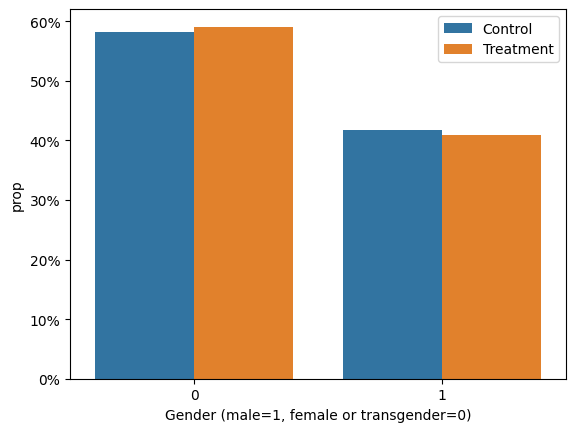

In [36]:
ax = sns.barplot(
    data=df.groupby('w')['gender_male'].value_counts(normalize=True).to_frame().set_axis(['prop'], axis=1),
    x="gender_male",
    y="prop",
    hue="w",
    )

ax.yaxis.set_major_formatter("{x:.0%}")
ax.set_xlabel("Gender (male=1, female or transgender=0)")
ax.legend(title='')
new_labels = ['Control', 'Treatment']  # Replace with your desired labels
for t, l in zip(ax.get_legend().texts, new_labels):
    t.set_text(l)

plt.show()

As we saw in section 1.1., there is a similar percentage of males and females participants in each treatment group in the sample. 

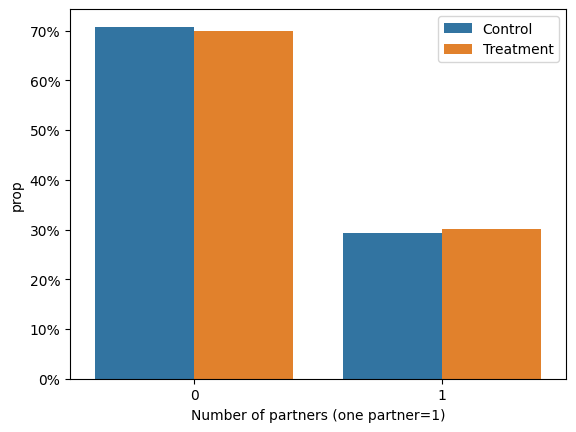

In [37]:
ax = sns.barplot(
    data=df.groupby('w')['partners1'].value_counts(normalize=True).to_frame().set_axis(['prop'], axis=1),
    x="partners1",
    y="prop",
    hue="w",
    )

ax.yaxis.set_major_formatter("{x:.0%}")
ax.set_xlabel("Number of partners (one partner=1)")
ax.legend(title='')
new_labels = ['Control', 'Treatment']  # Replace with your desired labels
for t, l in zip(ax.get_legend().texts, new_labels):
    t.set_text(l)

plt.show()

In a similar manner, we note an equal percentage of participants with 2 or more sexual partners as well as those with 1 sexual partner in the last 12 months from the beginning of the study, per treatment or control group.

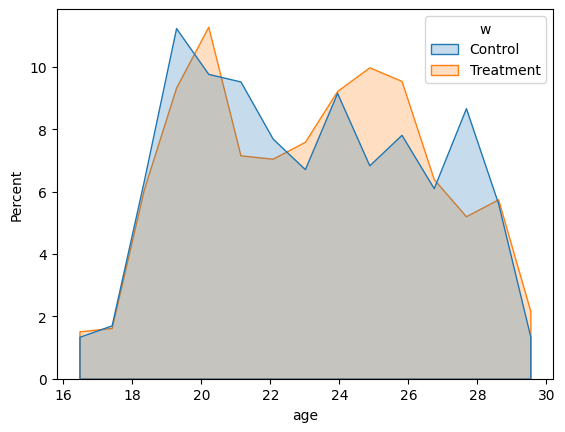

In [38]:
ax = sns.histplot(data=df, x="age", hue="w", element="poly", stat="percent", common_norm=False)

new_labels = ['Control', 'Treatment']  # Replace with your desired labels
for t, l in zip(ax.get_legend().texts, new_labels):
    t.set_text(l)

plt.show()

We can see a higher percentage of participants aged between 23 and 27 in the treatment group. Also, there is a higher perceptange of participants aged between 21 and 22 and 27 and 29 in the control group.

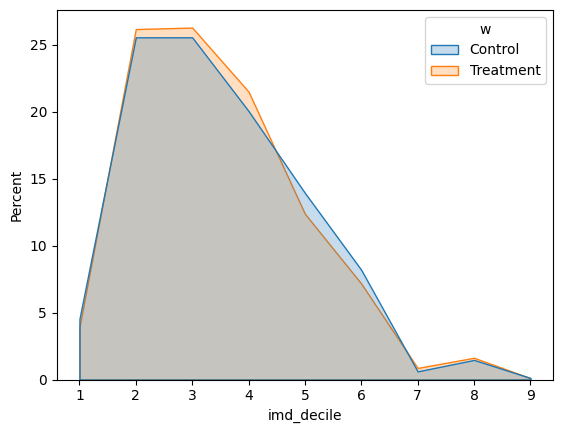

In [39]:
ax = sns.histplot(data=df, x="imd_decile", hue="w", element="poly", discrete=True, stat="percent", common_norm=False)

new_labels = ['Control', 'Treatment']  # Replace with your desired labels
for t, l in zip(ax.get_legend().texts, new_labels):
    t.set_text(l)

plt.show()

In the case of the IMD decile, an index that measures poverty in the UK, we can see the same proportion of participants in each group.

### 2. Linear Regression analysis

#### 2.1. Regression 1: $y = \beta_0 + \beta_1 T + \epsilon$

In [40]:
model_1 = "y ~ w"
est_1 = smf.ols(formula=model_1 , data=df).fit()

print(est_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     144.5
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           4.96e-32
Time:                        21:22:54   Log-Likelihood:                -1112.9
No. Observations:                1739   AIC:                             2230.
Df Residuals:                    1737   BIC:                             2241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2115      0.016     13.174      0.0

We found that the adjusted R-squared is 0.076 and the ATE is approximately 0.27. This means that the treatment explains only 7.6% of the increase in the STI tests between the control and treatment groups. Additionally, receiving the treatment (i.e. being invited to use the internet-based sexual health service) increases, on average, the probability of taking an STI test by 26.5%.

#### 2.2. Regression 2: $y = \beta_0 + \beta_1 T + \beta_2 X + \epsilon$

In [41]:
model_2 = "y ~ w + age + gender_female + ethnicgrp_white + ethnicgrp_black + ethnicgrp_mixed_multiple + partners1 + imd_decile + msm"
est_2 = smf.ols(formula=model_2 , data=df).fit()

print(est_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     22.94
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           3.06e-37
Time:                        21:22:54   Log-Likelihood:                -1084.3
No. Observations:                1739   AIC:                             2189.
Df Residuals:                    1729   BIC:                             2243.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Compared to the previous regression, when we include additional variables (age, gender, ethnic group, number of sexual partners, the indicator for Randomised after SH:24 made publicly available, the indicator for men who have sex with men, and the socioeconomic level measured by deciles), we observe an increase in the adjusted R-squared of approximately 0.3 percentage points (from 0.1). Additionally, the ATE decreases by 0.003 percentage points, indicating a negative bias.

It is worth mentioning that we omit gender_male to avoid collinearity with gender_female. Similarly, we exclude the less relevant ethnic group (i.e. the one with fewer observations) to prevent the same issue.

#### 2.3. Regression 3: $y = \beta_0 + \beta_1 T + \beta_2 X + \epsilon$ (Double Lasso variable selection)

In [48]:
# Assuming df is already defined
X = df[["gender_female", "ethnicgrp_white", "ethnicgrp_black", "gender_transgender", "msm", "partners1", "age", "imd_decile"]]
w = df['w']
y = df['y']

# Fit LassoCV model to find the optimal alpha (lambda)
cv_model3a = LassoCV(alphas=None, cv=10, max_iter=10000).fit(X, w)
cv_model3b = LassoCV(alphas=None, cv=10, max_iter=10000).fit(X, y)

# Fit Lasso model with the optimal alpha
model3a = Lasso(alpha=cv_model3a.alpha_).fit(X, w)
model3b = Lasso(alpha=cv_model3b.alpha_).fit(X, y)

# Identify non-zero coefficients from Lasso models
significant_vars3a = X.columns[model3a.coef_ != 0]
significant_vars3b = X.columns[model3b.coef_ != 0]

# Combine the significant variables from both models
significant_vars = pd.Index(np.unique(significant_vars3a.append(significant_vars3b)))

# Extract the significant variables for regression
X_significant = X[significant_vars]

# Add 'w' to the significant variables
X_significant_with_w = X_significant.copy()
X_significant_with_w['w'] = w

# Add constant term for intercept in the new significant variable set
X_significant_with_w = sm.add_constant(X_significant_with_w)

# Fit linear regression model on significant variables plus 'w' against 'y'
model3 = sm.OLS(y, X_significant_with_w).fit()

# Print summary of the model
print("Summary for the final model with dependent variable 'y':")
print(model3.summary())

Summary for the final model with dependent variable 'y':
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     34.38
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           2.06e-39
Time:                        21:30:47   Log-Likelihood:                -1084.5
No. Observations:                1739   AIC:                             2183.
Df Residuals:                    1732   BIC:                             2221.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

We observe that the ATE using double lasso is akin to the OLS with confounders, along with the adjusted R-squared.

#### 2.4. Coefficient Comparison

/var/folders/km/jc_93cpj0cv1jgmdmzcmqj6m0000gn/T/ipykernel_4903/1402500519.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(model_labels, coefficients, yerr=errors, fmt='o', capsize=5, capthick=2, marker='s', markersize=7, linestyle='None')


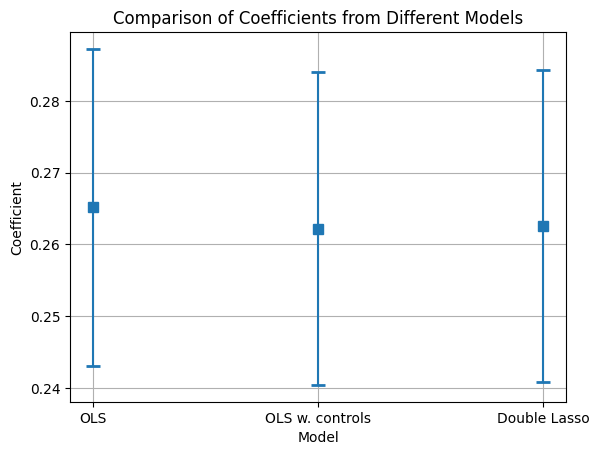

In [50]:
# Assuming model1, model2, model3 are your fitted statsmodels regression models
# Extract the coefficients for resW
b1 = est_1.params['w']
b2 = est_2.params['w']
b3 = model3.params['w']

# Extract the standard errors for resW
se1 = est_1.bse['w']
se2 = est_2.bse['w']
se3 = model3.bse['w']

# Labels for the models
model_labels = ['OLS', 'OLS w. controls', 'Double Lasso']

# Coefficients and standard errors
coefficients = [b1, b2, b3]
errors = [se1, se2, se3]

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the coefficients with error bars
ax.errorbar(model_labels, coefficients, yerr=errors, fmt='o', capsize=5, capthick=2, marker='s', markersize=7, linestyle='None')

# Add title and labels
ax.set_title('Comparison of Coefficients from Different Models')
ax.set_xlabel('Model')
ax.set_ylabel('Coefficient')

# Add grid for better readability
ax.grid(True)

# Show the plot
plt.show()

In general, the three ATEs are very similar, but we consider that the models that include the cofounders (OLS with controls and DL) are better estimated.

### 3. Non-Linear Methods DML

In [15]:
def dml(X, D, y, modely, modeld, *, nfolds, classifier=False, time = None, clu = None, cluster = True):
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123) # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1) # out-of-fold predictions for y
    # out-of-fold predictions for D
    # use predict or predict_proba dependent on classifier or regressor for D
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat

    if cluster:
      # final stage ols clustered
      dml_data = pd.concat([clu, pd.Series(time), pd.Series(resy, name = 'resy'), pd.Series(resD, name = 'resD')], axis=1)

    else:
      # final stage ols nonclustered
      dml_data = pd.concat([pd.Series(resy, name = 'resy'), pd.Series(resD, name = 'resD')], axis=1)

    if cluster:
      # clustered standard errors
      ols_mod = smf.ols(formula = 'resy ~ 1 + resD', data = dml_data).fit(cov_type='cluster', cov_kwds={"groups": dml_data['CountyCode']})

    else:
      # regular ols
      ols_mod = smf.ols(formula = 'resy ~ 1 + resD', data = dml_data).fit()

    point = ols_mod.params[1]
    stderr = ols_mod.bse[1]
    epsilon = ols_mod.resid

    return point, stderr, yhat, Dhat, resy, resD, epsilon


In [16]:
def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point, # point estimate
                         'stderr': stderr, # standard error
                         'lower': point - 1.96*stderr, # lower end of 95% confidence interval
                         'upper': point + 1.96*stderr, # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)), # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)) # RMSE of model that predicts treatment D
                         }, index=[name])

In [17]:
df['intercept'] = 1
y = df["y"]
d = df["w"]
x = df[df.columns[~df.columns.isin(['y','w'])]]

#### 3.1. DML with RLasso

In [18]:
class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])

lasso_model = lambda: RLasso(post=False)

In [20]:
# DML with RLasso:
modely = make_pipeline(StandardScaler(), RLasso(post=False))
modeld = make_pipeline(StandardScaler(), RLasso(post=False))
result_RLasso = dml(x,d,y, modely, modeld, nfolds=10, classifier=False, cluster = False)
table_RLasso = summary(*result_RLasso, x,d,y, name = 'Lasso')
print(table_RLasso)

       estimate    stderr     lower     upper    rmse y    rmse D
Lasso  0.259067  0.021722  0.216492  0.301642  0.471041  0.500225


C:\Users\Matias Villalba\AppData\Local\Temp\ipykernel_23460\2498640246.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point = ols_mod.params[1]
C:\Users\Matias Villalba\AppData\Local\Temp\ipykernel_23460\2498640246.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stderr = ols_mod.bse[1]


The message treatment providing information about Internet-accessed sexually transmitted 
infection testing predicts an increase in the probability that a person will get tested 
by 25.91 percentage points compared to receiving information about nearby clinics offering 
in-person testing. 
By providing both groups with information about testing, we mitigate the potential reminder 
effect, as both groups are equally prompted to consider testing. This approach allows us to 
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic 
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality 
rather than mere correlation, confirming that the intervention's effect is driven by the unique 
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and 
convenience

#### 3.2. DML with Regression Trees

In [22]:
modely = make_pipeline(StandardScaler(), DecisionTreeRegressor(ccp_alpha=0.001, min_samples_leaf=5, random_state=123))
modeld = make_pipeline(StandardScaler(), DecisionTreeRegressor(ccp_alpha=0.001, min_samples_leaf=5, random_state=123))
result_RT = dml(x,d,y, modely, modeld, nfolds=10, classifier=False, cluster = False)
table_RT= summary(*result_RT, x,d,y, name = 'RT')
print(table_RT)

    estimate    stderr     lower     upper    rmse y    rmse D
RT  0.249831  0.021872  0.206961  0.292701  0.472259  0.499638


C:\Users\Matias Villalba\AppData\Local\Temp\ipykernel_23460\2498640246.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point = ols_mod.params[1]
C:\Users\Matias Villalba\AppData\Local\Temp\ipykernel_23460\2498640246.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stderr = ols_mod.bse[1]


The message treatment providing information about Internet-accessed sexually transmitted 
infection testing predicts an increase in the probability that a person will get tested 
by 24.98 percentage points compared to receiving information about nearby clinics offering 
in-person testing. 
By providing both groups with information about testing, we mitigate the potential reminder 
effect, as both groups are equally prompted to consider testing. This approach allows us to 
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic 
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality 
rather than mere correlation, confirming that the intervention's effect is driven by the unique 
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and 
convenience

#### 3.3. DML Boosting Trees

In [24]:
modely = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=123))
modeld = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=123))
result_GBT = dml(x,d,y, modely, modeld, nfolds=10, classifier=False, cluster = False)
table_GBT = summary(*result_GBT, x,d,y, name = 'GBT')
print(table_GBT)

     estimate    stderr     lower     upper    rmse y    rmse D
GBT  0.246373  0.021669  0.203902  0.288843  0.475893  0.508383


C:\Users\Matias Villalba\AppData\Local\Temp\ipykernel_23460\2498640246.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point = ols_mod.params[1]
C:\Users\Matias Villalba\AppData\Local\Temp\ipykernel_23460\2498640246.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stderr = ols_mod.bse[1]


The message treatment providing information about Internet-accessed sexually transmitted 
infection testing predicts an increase in the probability that a person will get tested 
by 24.64 percentage points compared to receiving information about nearby clinics offering 
in-person testing. 
By providing both groups with information about testing, we mitigate the potential reminder 
effect, as both groups are equally prompted to consider testing. This approach allows us to 
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic 
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality 
rather than mere correlation, confirming that the intervention's effect is driven by the unique 
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and 
convenience

#### 3.4. DML with Random Forest

In [26]:
modely = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
modeld = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
result_RF = dml(x,d,y, modely, modeld, nfolds=10, classifier=False, cluster = False)
table_RF = summary(*result_RF, x,d,y, name = 'RF')
print(table_RF)

    estimate    stderr     lower     upper    rmse y    rmse D
RF  0.241558  0.021379  0.199655  0.283461  0.472297  0.511585


C:\Users\Matias Villalba\AppData\Local\Temp\ipykernel_23460\2498640246.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point = ols_mod.params[1]
C:\Users\Matias Villalba\AppData\Local\Temp\ipykernel_23460\2498640246.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stderr = ols_mod.bse[1]


The message treatment providing information about Internet-accessed sexually transmitted 
infection testing predicts an increase in the probability that a person will get tested 
by 24.16 percentage points compared to receiving information about nearby clinics offering 
in-person testing. 
By providing both groups with information about testing, we mitigate the potential reminder 
effect, as both groups are equally prompted to consider testing. This approach allows us to 
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic 
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality 
rather than mere correlation, confirming that the intervention's effect is driven by the unique 
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and 
convenience

#### 3.6.

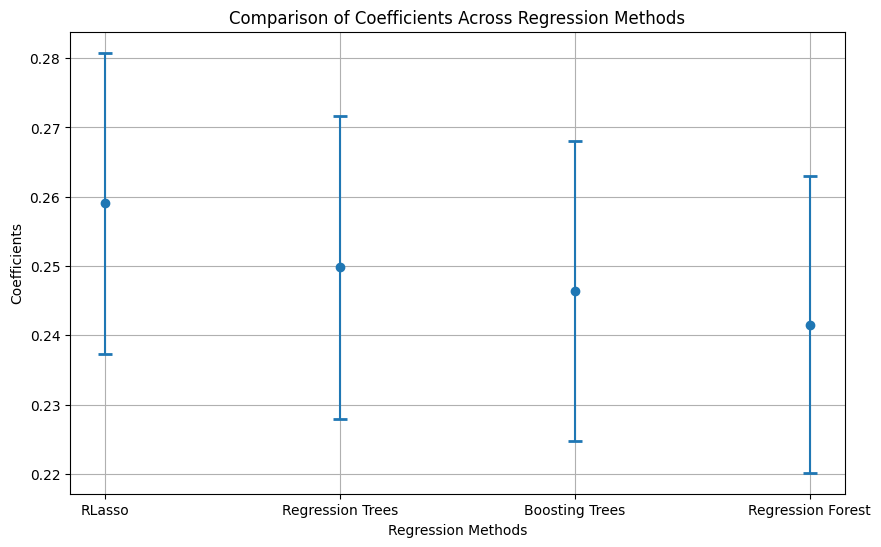

In [31]:
# Extract coefficients and standard errors
coefficients = [result_RLasso[0], result_RT[0], result_GBT[0], result_RF[0]]
standard_errors = [result_RLasso[1], result_RT[1], result_GBT[1], result_RF[1]]
methods = ['RLasso', 'Regression Trees', 'Boosting Trees', 'Regression Forest']

# Plotting the coefficients with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(methods, coefficients, yerr=standard_errors, fmt='o', capsize=5, capthick=2)
plt.xlabel('Regression Methods')
plt.ylabel('Coefficients')
plt.title('Comparison of Coefficients Across Regression Methods')
plt.grid(True)
plt.show()

In [32]:
results_table = pd.concat([table_RLasso, table_RT, table_GBT, table_RF], axis=0)
print(results_table)

       estimate    stderr     lower     upper    rmse y    rmse D
Lasso  0.259067  0.021722  0.216492  0.301642  0.471041  0.500225
RT     0.249831  0.021872  0.206961  0.292701  0.472259  0.499638
GBT    0.246373  0.021669  0.203902  0.288843  0.475893  0.508383
RF     0.241558  0.021379  0.199655  0.283461  0.472297  0.511585


To choose the best model, we must compare the RMSEs of the outcome variable Y. In this case, the model with the lowest RMSE for Y 
is generated by Lasso (0.471041), whereas the lowest for the treatment is generated by Regression Trees (0.4983734). Therefore, DML 
could be employed with Y cleaned using Lasso and the treatment using Regression Trees.